# Graphical Models: Similarity Distribution Experimentation

In [1]:
# Import necessary libraries
import networkx as nx
from networkx.algorithms import approximation
from networkx.algorithms.approximation import independent_set, clique
import matplotlib.pyplot as plt
import random, itertools as it
from scipy.special import comb
import pandas as pd
import numpy as np

## Similarity Implementations

### General Methods

In [2]:
# get all children in a dictionary including their respective weights (chains taken into account)
def get_all_children(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_all_children(graph, i[1], children_dict=children_dict, carry=weights[i])
    return children_dict

In [3]:
# (Adapted from function above)
# Get all children in a dictionary including their respective weights (chains taken into account)
def get_descendants(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_descendants(graph, i[1], children_dict=children_dict, carry=weights[i])
    
    return children_dict

In [4]:
# Returns children of a single node
def get_children(gm, parent):
    children_weights = {}
    weights = nx.get_edge_attributes(gm, 'weight')
    
    for i in gm.out_edges(parent):
        children_weights[i[1]] = weights[i]

    return children_weights

In [5]:
def find_node_children_subgraph(graph, snode, childgraph):
    cnodes = graph.neighbors(snode)
    edges = nx.edges(graph)
    for i in cnodes:
        childgraph.add_node(i)
        childgraph.add_edge(snode, i)
        childgraph = find_node_children_subgraph(graph, i, childgraph)
    return childgraph

### Jaccard Index

In [6]:
# all children of rain
def calculate_intersection(graph, children_a, children_b):
    inter = 0
    for i in children_a:
        if i in children_b:
            if children_a[i] < children_b[i]:
                inter += children_a[i]
            else:
                inter += children_b[i]
    return inter  

In [7]:
# helper func to calculate the union using method 1
def calculate_union_1(graph, children_a, children_b):
    union = 0
    for i in children_a:
        union += children_a[i]
    for i in children_b:
        union += children_b[i]
    union -= calculate_intersection(graph, children_a, children_b)
    return union

In [8]:
# helper func to calculate the union using method 2
def calculate_union_2(graph, children_a, children_b):
    union = 0
    for i in children_a:
        if i in children_b:
            union += abs(children_a[i] - children_b[i])
        else:
            union += children_a[i]
    for i in children_b:
        if not i in children_a:
            union += children_b[i]
    return union

In [9]:
# calculate the similarity, compares both methods
def calculate_similarity(graph, node_a, node_b):
    children_a = get_all_children(graph, node_a, {})
    children_b = get_all_children(graph, node_b, {})
    intersection = calculate_intersection(graph, children_a, children_b)
    union_1 = calculate_union_1(graph, children_a, children_b)
    union_2 = calculate_union_2(graph, children_a, children_b)
    
    method_1_results = 0
    method_2_results = 0
    
    if union_1 != 0:
        method_1_results = intersection/union_1
    if union_2 != 0:
        method_2_results = intersection/union_2
        
    results = {"method 1": method_1_results, "method 2": method_2_results}
    
    return results

### Edit-Distance

Edit-distance similarity implementation based only on a node's children.

In [10]:
# Returns the similarity of node B compared to node A, based on 
# children
def get_immediate_similarity(gm, A, B):
    cost = 0.0
    A_children = get_children(gm, A)
    B_children = get_children(gm, B)
    
    if len(A_children) > 0:
        for child in A_children:
            if child in B_children:
                diff = abs(A_children[child] - B_children[child])
                cost += diff
            else:
                cost += 1

        return cost / len(A_children)
    
    else:
        return 0

In [11]:
# Returns the node that is most similar to the input node
def find_most_immediate_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_immediate_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_immediate_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

Edit-distance similarity implementation based on all descendants of a node.

In [12]:
# Returns the similarity of node B compared to node A
def get_full_similarity(gm, A, B):
    cost = 0.0
    A_children = get_descendants(gm, A, {}, 1)
    B_children = get_descendants(gm, B, {}, 1)
    
    if len(A_children) > 0:
        for child in A_children:
            if child in B_children:
                diff = abs(A_children[child] - B_children[child])
                cost += diff
            else:
                cost += 1

        return cost / len(A_children)
    
    else:
        return 0

# Optional print line in for loop for debugging: 
# print(child, A_children[child], B_children[child])

In [13]:
# Returns the node that is most similar to the input node
def find_most_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_full_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_full_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

### NetworkX: Edit-Distance

In [14]:
# nx.graph_edit_distance(Graph1, Graph2)

### NetworkX: SimRank

In [15]:
# nx.algorithms.similarity.simrank_similarity(graph, source="node_a", target="node_b")

## Generating Random Directed Graphs

In [16]:
def addNodes(gm, num_nodes):
    node_list = []
    
    for i in range(num_nodes):
        gm.add_node(i)

    return gm

In [17]:
# NOTE: This function does not have functionality implemented yet that 
# prevents cycles from occurring
def addEdges(gm, num_nodes, num_edges):
    for i in range(num_edges):
        parent = random.randrange(num_nodes)
        child = random.randrange(num_nodes)
        
        conditional_prob = random.uniform(0, 1)
        gm.add_edge(parent, child, weight=conditional_prob)
            
        if not nx.is_directed_acyclic_graph(gm):
            gm.remove_edge(parent, child)
        
    return gm

In [18]:
# def find_paths(graph, start, end, path=[]):
#     if start == end:
#         return path
    
#     children = get_children(graph, start)
    
#     for node in children:
#         find_paths(graph, start)

In [19]:
def makeDirectedGraph(num_nodes, num_edges):
    dg = nx.DiGraph() # creates directed graph
    dg = addNodes(dg, num_nodes)
    dg = addEdges(dg, num_nodes, num_edges)
    return dg

In [20]:
dg = makeDirectedGraph(3, 15)

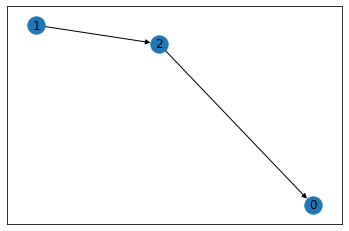

In [21]:
nx.draw_networkx(dg)

## Running Experiments

In [22]:
def getSimilarityData(gm):
    node_list = list(gm.nodes)
    node_pairs = list(it.combinations(node_list, 2))

    ed_immediate_sim, ed_full_sim, ji_sim_1, ji_sim_2 = [], [], [], []

    for pair in node_pairs:
        ed_immediate_sim.append(get_immediate_similarity(gm, pair[0], pair[1]))
        ed_immediate_sim.append(get_immediate_similarity(gm, pair[1], pair[0]))

        ed_full_sim.append(get_full_similarity(gm, pair[0], pair[1]))
        ed_full_sim.append(get_full_similarity(gm, pair[1], pair[0]))

        ji_sim_1.append(calculate_similarity(gm, pair[0], pair[1])["method 1"])
        ji_sim_1.append(calculate_similarity(gm, pair[1], pair[0])["method 1"])

        ji_sim_2.append(calculate_similarity(gm, pair[0], pair[1])["method 2"])
        ji_sim_2.append(calculate_similarity(gm, pair[1], pair[0])["method 2"])

    similarity_data = {"Edit-Distance Immediate Similarity": ed_immediate_sim, "Edit-Distance Full Similarity": ed_full_sim,
           "Jaccard Index Similarity (Method 1)": ji_sim_1, "Jaccard Index Similarity (Method 2)": ji_sim_2}
        
    return similarity_data

In [23]:
def getCliqueData(gm):
    node_list = list(gm.nodes)
    num_rows = len(list(it.combinations(node_list, 2))) * 2
    
    longest_max_indep_set = len(independent_set.maximum_independent_set(gm))
    max_cliques = list(clique.clique_removal(gm)[1]) * num_rows
    num_max_cliques = len(max_cliques)
    longest_max_clique = len(max_cliques[0])
    
    clique_data = {"Longest Maximum Independent Set": [longest_max_indep_set] * num_rows,
                   "Number of Maximum Cliques": [num_max_cliques] * num_rows, 
                   "Longest Maximum Clique": [longest_max_clique] * num_rows}
    
    return clique_data

In [24]:
def runExperiment(num_graphs, num_nodes, num_edges): 
    graph_df_list = []
    
    for i in range(num_graphs):
        dg = makeDirectedGraph(num_nodes, num_edges)
        
        similarity_data = getSimilarityData(dg)
        clique_data = getCliqueData(dg)
                
        similarity_data.update(clique_data)
                        
        graph_df = pd.DataFrame(data = similarity_data)
        
        graph_df_list.append(graph_df)
    
    return graph_df_list

In [ ]:
new_experiment_data = runExperiment(30, 100, 150)
new_experiment_data[0]

In [ ]:
#experiment_data = runExperiment(25, 100, 100)

# This block is commented because it takes over 7 minutes to runExperiment() on that large of a graph (100 nodes)

### Condensing Data

In [ ]:
# condenseExperimentData() takes the output of runExperiment as an input.
# Returns a DataFrame consisting of averages for each similarity index
def condenseExperimentData(experiment_data):
    ed_immediate_sim_avgs, ed_full_sim_avgs, ji_sim_1_avgs, ji_sim_2_avgs = [], [], [], []
    longest_max_ind_set_avgs, num_max_cliques_avgs, longest_max_clique_avgs = [], [], []
    
    for graph_df in experiment_data:
        graph_avgs = graph_df.mean(axis=0)
        ed_immediate_sim_avgs.append(graph_avgs["Edit-Distance Immediate Similarity"])
        ed_full_sim_avgs.append(graph_avgs["Edit-Distance Full Similarity"])
        ji_sim_1_avgs.append(graph_avgs["Jaccard Index Similarity (Method 1)"])
        ji_sim_2_avgs.append(graph_avgs["Jaccard Index Similarity (Method 2)"])
        longest_max_ind_set_avgs.append(graph_avgs["Longest Maximum Independent Set"])
        num_max_cliques_avgs.append(graph_avgs["Number of Maximum Cliques"])
        longest_max_clique_avgs.append(graph_avgs["Longest Maximum Clique"])
        
    condensed_data = {"Edit-Distance Immediate Similarity Averages": ed_immediate_sim_avgs,
                     "Edit-Distance Full Similarity Averages": ed_full_sim_avgs,
                     "Jaccard Index Similarity (Method 1) Averages": ji_sim_1_avgs,
                     "Jaccard Index Similarity (Method 2) Averages": ji_sim_2_avgs,
                     "Longest Maximum Independent Set": longest_max_ind_set_avgs,
                     "Number of Maximum Cliques": num_max_cliques_avgs,
                     "Longest Maximum Clique": longest_max_clique_avgs}
    condensed_df = pd.DataFrame(data = condensed_data)
    
    return condensed_df

In [ ]:
condensed_df = condenseExperimentData(new_experiment_data)
condensed_df

### Running Multiple Experiments

In [ ]:
nodes_to_edges_factor = 1.5
def runMultipleExperiments(num_graphs, start_num_nodes, end_num_nodes, step):
    experiments_df = pd.DataFrame(columns = ["Nodes", "Edit-Distance Immediate Similarity",
                                            "Edit-Distance Full Similarity",
                                            "Jaccard Index Similarity (Method 1)",
                                            "Jaccard Index Similarity (Method 2)",
                                            "Longest Maximum Independent Set",
                                            "Number of Maximum Cliques",
                                            "Longest Maximum Clique"])
    
    for num_nodes in range(start_num_nodes, end_num_nodes, step):
        num_edges = int(num_nodes * 1.5)
        experiment_data = runExperiment(num_graphs, num_nodes, num_edges)
        condensed_data = condenseData(experiment_data)
        condensed_data_avgs = condensed_data.mean(axis=0)
        experiments_df.append({"Nodes": num_nodes,
                              "Edit-Distance Immediate Similarity": condensed_data_avgs["Edit-Distance Immediate Similarity"],
                                "Edit-Distance Full Similarity": condensed_data_avgs["Edit-Distance Full Similarity"],
                                "Jaccard Index Similarity (Method 1)": condensed_data_avgs["Jaccard Index Similarity (Method 1)"],
                                "Jaccard Index Similarity (Method 2)": condensed_data_avgs["Jaccard Index Similarity (Method 2)"],
                                "Longest Maximum Independent Set": condensed_data_avgs["Longest Maximum Independent Set"],
                                "Number of Maximum Cliques": condensed_data_avgs["Number of Maximum Cliques"],
                                "Longest Maximum Clique": condensed_data_avgs["Longest Maximum Clique"]}, ignore_index=True)
    
    return experiments_df    

In [ ]:
runMultipleExperiments(5, 5, 8, 1)

## Exporting Data

In [ ]:
condensed_df.to_csv("Data/similarity-distribution-experiment.csv", index=True)